
# Регрессия: «своими руками» и с помощью библиотек

В этом ноутбуке вы:
1. Сгенерируете синтетические данные с линейной зависимостью.
2. Оцените линейную регрессию **с нуля**:
   - нормальное уравнение (аналитическое решение);
   - градиентный спуск.
3. Построите регрессию **с помощью библиотек** (`scikit-learn`).
4. Сравните метрики (MSE, R²) на train/test и визуализируете результаты.

> Примечания по графикам: используем только `matplotlib`, каждый график — отдельный рисунок, без заданных цветов.


In [6]:

# Базовые импорты
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Настройки печати
np.set_printoptions(suppress=True, precision=4)
pd.set_option("display.float_format", lambda v: f"{v:.4f}")

# Функции метрик
def mse(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return np.mean((y_true - y_pred) ** 2)

def r2_score(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot



## 1) Синтетические данные

Создадим данные по формуле:

$
y = 3x + 2 + \varepsilon,\quad \varepsilon \sim \mathcal{N}(0,\,1)
$

А затем разделим на train/test.


Train size: 90, Test size: 30


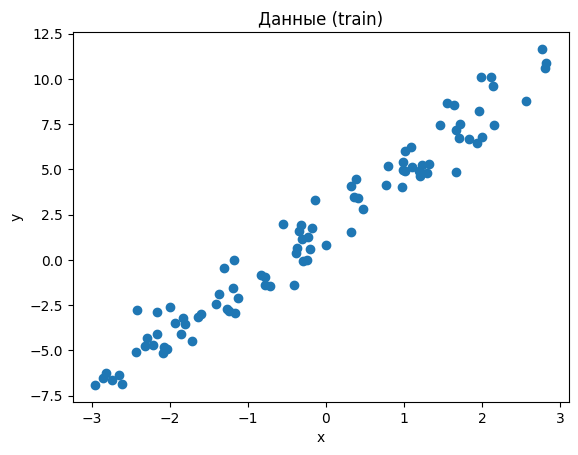

In [7]:

rng = np.random.default_rng(42)
n = 120
X = rng.uniform(-3, 3, size=(n, 1))
noise = rng.normal(0, 1, size=(n, 1))
y = 3 * X + 2 + noise

# Train/Test split
idx = np.arange(n)
rng.shuffle(idx)
train_size = int(0.75 * n)
train_idx, test_idx = idx[:train_size], idx[train_size:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# Быстрый scatter
plt.figure()
plt.scatter(X_train, y_train, label="train")
plt.title("Данные (train)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()



## 2) Линейная регрессия «с нуля»: нормальное уравнение

Добавим столбец единиц и решим $(\hat{\beta} = (X^\top X)^{-1} X^\top y)$.


Оценки коэффициентов [beta0, beta1]: [1.9833 3.0305]
MSE train: 0.9844082710190326
MSE test : 1.1204578640928564
R^2  train: 0.9606429885046189
R^2  test : 0.9490803078316056


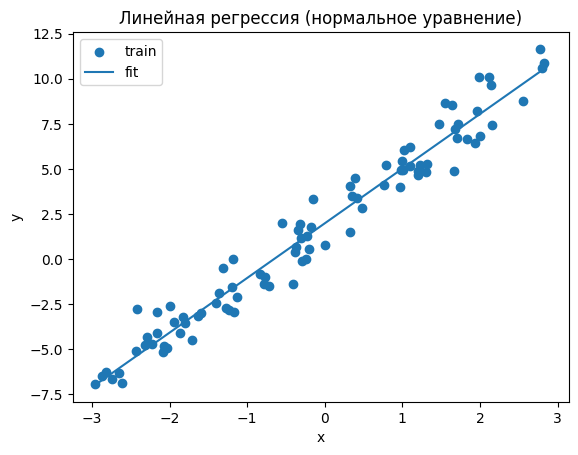

In [8]:

def add_intercept(X):
    X = np.asarray(X)
    return np.hstack([np.ones((X.shape[0], 1)), X])

Xb_train = add_intercept(X_train)
Xb_test  = add_intercept(X_test)

# Закрытая форма (псевдообратная на случай вырожденности)
beta_hat = np.linalg.pinv(Xb_train.T @ Xb_train) @ (Xb_train.T @ y_train)

y_pred_train = Xb_train @ beta_hat
y_pred_test  = Xb_test  @ beta_hat

print("Оценки коэффициентов [beta0, beta1]:", beta_hat.reshape(-1))

print("MSE train:", mse(y_train, y_pred_train))
print("MSE test :", mse(y_test, y_pred_test))
print("R^2  train:", r2_score(y_train, y_pred_train))
print("R^2  test :", r2_score(y_test, y_pred_test))

# Визуализация прямой
xs = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
ys = add_intercept(xs) @ beta_hat

plt.figure()
plt.scatter(X_train, y_train, label="train")
plt.plot(xs, ys, label="fit")
plt.title("Линейная регрессия (нормальное уравнение)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()



## 3) Линейная регрессия «с нуля»: градиентный спуск

Минимизируем $J(\beta)=\frac{1}{n}\sum (y-\hat{y})^2$ по $\beta$.


GD коэффициенты [beta0, beta1]: [1.9833 3.0305]
MSE train: 0.9844082710190326
MSE test : 1.1204578640928564
R^2  train: 0.9606429885046189
R^2  test : 0.9490803078316056


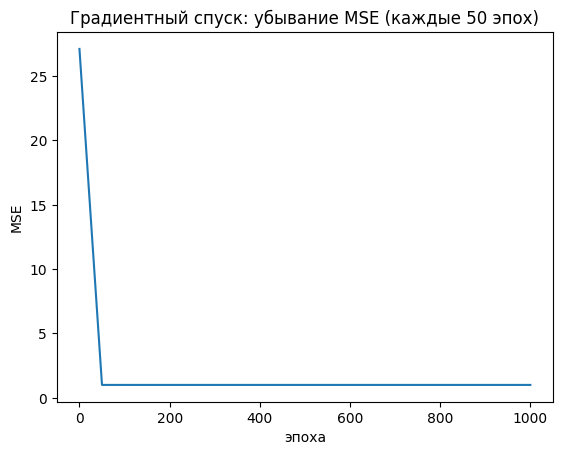

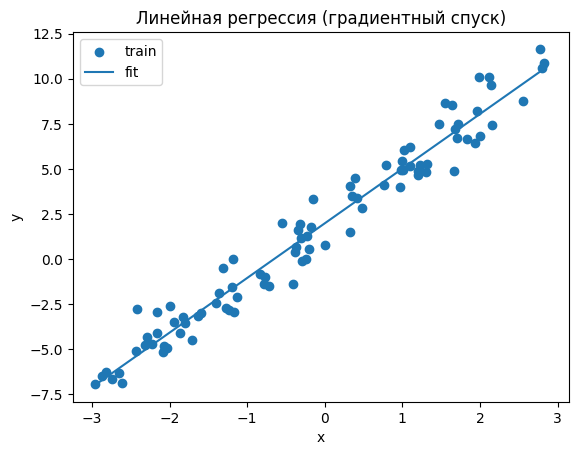

In [9]:

def gradient_descent_linreg(X, y, lr=0.05, epochs=1000):
    Xb = add_intercept(X)
    y = y.reshape(-1, 1)
    n, d = Xb.shape
    beta = np.zeros((d, 1))
    history = []
    for t in range(epochs):
        y_hat = Xb @ beta
        grad = (-2.0 / n) * (Xb.T @ (y - y_hat))
        beta -= lr * grad
        if t % 50 == 0 or t == epochs - 1:
            history.append(float(mse(y, y_hat)))
    return beta, history

beta_gd, hist = gradient_descent_linreg(X_train, y_train, lr=0.05, epochs=1000)

y_pred_train_gd = add_intercept(X_train) @ beta_gd
y_pred_test_gd  = add_intercept(X_test)  @ beta_gd

print("GD коэффициенты [beta0, beta1]:", beta_gd.reshape(-1))
print("MSE train:", mse(y_train, y_pred_train_gd))
print("MSE test :", mse(y_test, y_pred_test_gd))
print("R^2  train:", r2_score(y_train, y_pred_train_gd))
print("R^2  test :", r2_score(y_test, y_pred_test_gd))

# Кривая обучения (значение функции потерь по эпохам)
plt.figure()
plt.plot(np.arange(len(hist)) * 50, hist)
plt.title("Градиентный спуск: убывание MSE (каждые 50 эпох)")
plt.xlabel("эпоха")
plt.ylabel("MSE")
plt.show()

# Линия регрессии после GD
xs = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
ys_gd = add_intercept(xs) @ beta_gd

plt.figure()
plt.scatter(X_train, y_train, label="train")
plt.plot(xs, ys_gd, label="fit")
plt.title("Линейная регрессия (градиентный спуск)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()



## 4) Регрессия с библиотеками (`scikit-learn`)

Используем `LinearRegression` и `Ridge`. Затем сравним метрики.


In [10]:

from sklearn.linear_model import LinearRegression, Ridge

lr = LinearRegression()
lr.fit(X_train, y_train)
y_tr_lr = lr.predict(X_train)
y_te_lr = lr.predict(X_test)

ridge = Ridge(alpha=1.0, fit_intercept=True, random_state=42)
ridge.fit(X_train, y_train)
y_tr_rg = ridge.predict(X_train)
y_te_rg = ridge.predict(X_test)

import pandas as pd
res = pd.DataFrame({
    "model": ["LinearRegression", "Ridge(alpha=1)"],
    "MSE_train": [mse(y_train, y_tr_lr), mse(y_train, y_tr_rg)],
    "MSE_test":  [mse(y_test,  y_te_lr), mse(y_test,  y_te_rg)],
    "R2_train":  [r2_score(y_train, y_tr_lr), r2_score(y_train, y_tr_rg)],
    "R2_test":   [r2_score(y_test,  y_te_lr), r2_score(y_test,  y_te_rg)],
})
res


,model,MSE_train,MSE_test,R2_train,R2_test
0,LinearRegression,0.9844,1.1205,0.9606,0.9491
1,Ridge(alpha=1),0.9848,1.1121,0.9606,0.9495



## Выводы
- **С нуля**: нормальное уравнение даёт ту же прямую, что и `LinearRegression`, при хорошей обусловленности;
- **Градиентный спуск** сходится к тем же коэффициентам при адекватной скорости обучения и числе эпох;
